<a href="https://colab.research.google.com/github/S07092001/ML-Work/blob/main/gnn_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install xgboost scikit-learn pandas matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

# Upload from Kaggle / Drive
train_tx = pd.read_csv("/content/train_transaction.csv")
train_id = pd.read_csv("/content/train_identity.csv")

df = train_tx.merge(train_id, on="TransactionID", how="left")
df.fillna(0, inplace=True)

y = df["isFraud"]

In [3]:
features = [
    'TransactionAmt',#Real transaction value
    'ProductCD', #A code representing the product category involved in the transaction
    'card1', 'card2', 'card3', 'card5',
    'addr1',#Billing address region code
    'addr2',#Billing country or broader location code
    'dist1',#Distance between billing address and shipping address
    'dist2'#Distance between device location and known address
]

df = df[features + ['isFraud']]

# Encode categorical
from sklearn.preprocessing import LabelEncoder

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop("isFraud", axis=1)
y = df["isFraud"]


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    eval_metric='auc'
)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [7]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    max_iter=20
)
mlp.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20)

In [8]:
import torch
from torch_geometric.data import Data

edge_index = []

card_groups = df.groupby('card1').indices

for _, idxs in card_groups.items():
    for i in range(len(idxs)-1):
        edge_index.append([idxs[i], idxs[i+1]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

x = torch.tensor(X.values, dtype=torch.float)
y_tensor = torch.tensor(y.values, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y_tensor)


In [9]:
import torch
from torch_geometric.data import Data

edge_index = []

card_groups = df.groupby('card1').indices

for _, idxs in card_groups.items():
    for i in range(len(idxs)-1):
        edge_index.append([idxs[i], idxs[i+1]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

x = torch.tensor(X.values, dtype=torch.float)
y_tensor = torch.tensor(y.values, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y_tensor)


In [10]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class FraudGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(x.shape[1], 64)
        self.conv2 = GCNConv(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

model = FraudGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


In [11]:
model.train()
for epoch in range(30):
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.4f}")


Epoch 0 | Loss 1597.0491
Epoch 5 | Loss 48.8461
Epoch 10 | Loss 91.5149
Epoch 15 | Loss 111.0735
Epoch 20 | Loss 118.4175
Epoch 25 | Loss 118.4911


In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [13]:
models = {
    "Logistic": lr,
    "XGBoost": xgb,
    "MLP": mlp
}

results = {}

for name, m in models.items():
    preds = m.predict(X_test)
    probs = m.predict_proba(X_test)[:,1]
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "AUC": roc_auc_score(y_test, probs),
        "CM": confusion_matrix(y_test, preds)
    }


In [14]:
model.eval()
with torch.no_grad():
    gnn_logits = model(data)
    gnn_preds = gnn_logits.argmax(dim=1)

results["GNN"] = {
    "Accuracy": accuracy_score(y, gnn_preds.numpy()),
    "AUC": roc_auc_score(y, gnn_logits[:,1].numpy()),
    "CM": confusion_matrix(y, gnn_preds.numpy())
}


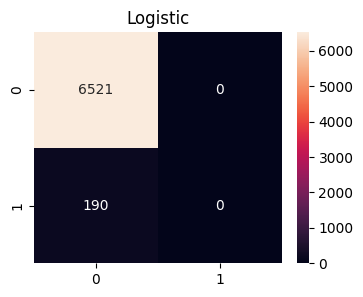

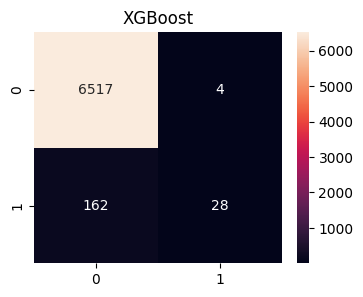

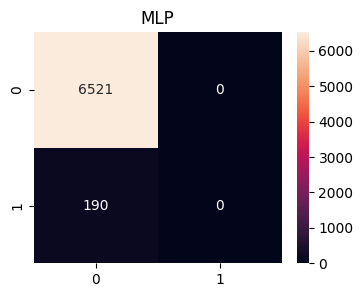

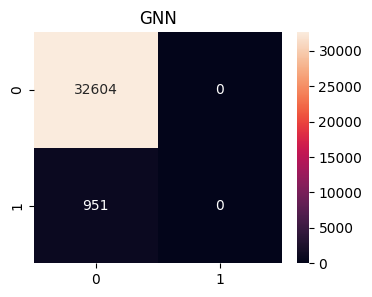

In [15]:
for name, res in results.items():
    plt.figure(figsize=(4,3))
    sns.heatmap(res["CM"], annot=True, fmt="d")
    plt.title(name)
    plt.show()


In [18]:
def user_predict(model_name):
    user_input = []
    for col in X.columns:
        val = float(input(f"Enter {col}: "))
        user_input.append(val)

    user_input = np.array(user_input).reshape(1,-1)

    if model_name == "GNN":
        out = model(torch.tensor(user_input, dtype=torch.float))
        pred = torch.argmax(out).item()
    else:
        pred = models[model_name].predict(user_input)[0]

    print("Fraud" if pred == 1 else "Not Fraud")


In [19]:
def gnn_user_predict(model, data, feature_names):
    """
    User interactive prediction for GNN
    """

    print("\nEnter transaction details:\n")

    user_values = []
    for col in feature_names:
        val = float(input(f"Enter {col}: "))
        user_values.append(val)

    user_x = torch.tensor(user_values, dtype=torch.float).unsqueeze(0)

    # -----------------------------
    # Add user node to graph
    # -----------------------------
    new_x = torch.cat([data.x, user_x], dim=0)
    new_node_id = new_x.shape[0] - 1

    # -----------------------------
    # Connect user node to similar nodes
    # Example: same card1
    # -----------------------------
    card1_index = feature_names.index("card1")
    user_card1 = user_x[0, card1_index]

    connected_nodes = torch.where(
        data.x[:, card1_index] == user_card1
    )[0]

    edge_list = []

    for node in connected_nodes:
        edge_list.append([node.item(), new_node_id])
        edge_list.append([new_node_id, node.item()])

    if len(edge_list) == 0:
        print("⚠️ No similar transactions found, connecting to random node")
        edge_list = [[0, new_node_id], [new_node_id, 0]]

    new_edges = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    new_edge_index = torch.cat([data.edge_index, new_edges], dim=1)

    # -----------------------------
    # Create new Data object
    # -----------------------------
    new_data = Data(
        x=new_x,
        edge_index=new_edge_index
    )

    # -----------------------------
    # Predict
    # -----------------------------
    model.eval()
    with torch.no_grad():
        logits = model(new_data)
        probs = torch.softmax(logits[new_node_id], dim=0)
        pred = torch.argmax(probs).item()

    print("\n🧠 GNN Prediction Result:")
    print(f"Fraud Probability     : {probs[1].item():.4f}")
    print(f"Non-Fraud Probability : {probs[0].item():.4f}")
    print("🔴 FRAUD" if pred == 1 else "🟢 NOT FRAUD")


In [20]:
gnn_user_predict(
    model=model,
    data=data,
    feature_names=X.columns.tolist()
)



Enter transaction details:

Enter TransactionAmt: 125.5
Enter ProductCD: 2
Enter card1: 12345
Enter card2: 150
Enter card3: 232
Enter card5: 534
Enter addr1: 243
Enter addr2: 52
Enter dist1: 21
Enter dist2: 42
⚠️ No similar transactions found, connecting to random node

🧠 GNN Prediction Result:
Fraud Probability     : 0.0000
Non-Fraud Probability : 1.0000
🟢 NOT FRAUD
